# OVERVIEW

This R Markdown script uses the **_Boston Housing_** data set to illustrate the following:

- The **$k$-Nearest Neighbors** (**KNN**) algorithm;
- The **Bias-Variance Trade-Off**; and
- The use of **Cross Validation** to estimate Out-of-Sample (OOS) prediction error and determine optimal hyper-parameters, in this case the number of nearest neighbors $k$. 

# _first, some boring logistics..._

Let's first import some necessary Python packages and helper modules from our **_zzz Utility Code_** folder, and set the random number generator's seed:

In [118]:
# enable In-Line MatPlotLib
%matplotlib inline

In [119]:
# import:
from __future__ import division, print_function
from ggplot import aes, ggplot, geom_line, geom_point, ggtitle, scale_color_manual, theme, xlab, ylab
from matplotlib import rcParams
from numpy import atleast_2d, log, nan, sqrt
from pandas import DataFrame, melt, read_csv
from random import seed
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sys import path

path.append('../../zzz Utility Code/Python')
from Helpy import rmse

seed(99)

# Boston Housing data set

Let's now import the Boston Housing data into a **`pandas`** data frame:

In [120]:
# read Boston Housing data into data frame
boston_housing = read_csv(
    'https://raw.githubusercontent.com/ChicagoBoothML/MachineLearning_Fall2015/master/Programming%20Scripts/Boston%20Housing/DATA_BostonHousing.csv')
boston_housing.sort(columns='lstat', inplace=True)
nb_samples = len(boston_housing)
boston_housing

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
161,1.46336,0.0,19.58,0,0.6050,7.489,90.8,1.9709,5,403,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1,0.6050,7.802,98.2,2.0407,5,403,14.7,389.61,1.92,50.0
40,0.03359,75.0,2.95,0,0.4280,7.024,15.8,5.4011,3,252,18.3,395.62,1.98,34.9
232,0.57529,0.0,6.20,0,0.5070,8.337,73.3,3.8384,8,307,17.4,385.91,2.47,41.7
192,0.08664,45.0,3.44,0,0.4370,7.178,26.3,6.4798,5,398,15.2,390.49,2.87,36.4
204,0.02009,95.0,2.68,0,0.4161,8.034,31.9,5.1180,4,224,14.7,390.55,2.88,50.0
3,0.03237,0.0,2.18,0,0.4580,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
370,6.53876,0.0,18.10,1,0.6310,7.016,97.5,1.2024,24,666,20.2,392.05,2.96,50.0
195,0.01381,80.0,0.46,0,0.4220,7.875,32.0,5.6484,4,255,14.4,394.23,2.97,50.0
275,0.09604,40.0,6.41,0,0.4470,6.854,42.8,4.2673,4,254,17.6,396.90,2.98,32.0


Let us then focus on the two variables of interest: **`lstat`** (our predictor variable(s) $\mathbf X$) and **`medv`** (our variable to predict $\mathbf y$). Below is a plot of them against each other:

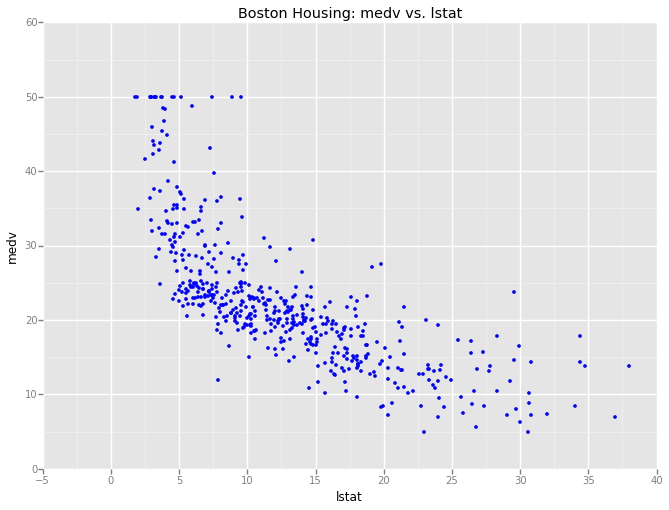

<ggplot: (284020865)>

In [121]:
ggplot(aes(x='lstat', y='medv'), data=boston_housing) +\
    geom_point(size=10, color='blue') +\
    ggtitle('Boston Housing: medv vs. lstat') +\
    xlab('lstat') + ylab('medv')

# $k$-Nearest Neighbors algorithm and Bias-Variance Trade-Off

Let's now try fitting a KNN predictor, with $k = 5$, of _medv_ from _lstat_, using all samples:

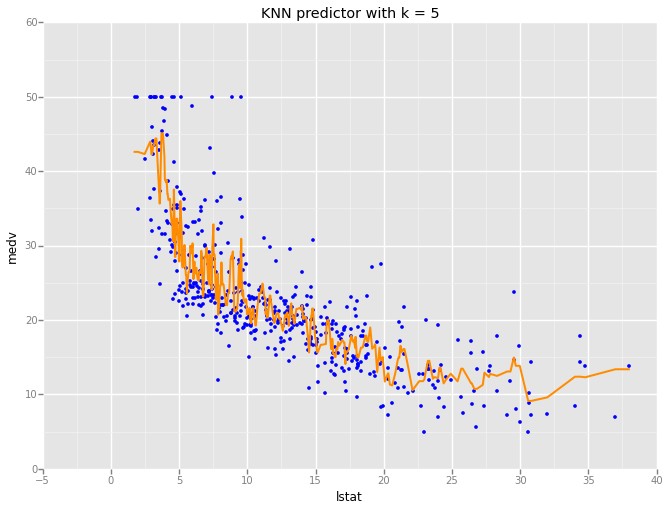

<ggplot: (282122789)>

In [122]:
k = 5
knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)
boston_housing['predicted_medv'] = knn_model.predict(boston_housing[['lstat']])

ggplot(aes(x='lstat', y='medv'), data=boston_housing) +\
    geom_point(size=10, color='blue') +\
    geom_line(aes(x='lstat', y='predicted_medv'), size=2, color='darkorange') +\
    ggtitle('KNN predictor with k = %i' % k) +\
    xlab('lstat') + ylab('medv')

With $k = 5$ &ndash; a small number of nearest neighbors &ndash; we have a very "squiggly" predictor, which **fits the training data well** but is **over-sensitive to small changes** in the _lstat_ variable. We call this a **LOW-BIAS**, **HIGH-VARIANCE** predictor. We don't like it.

Now, with, say, $k = 200$, we have the following:

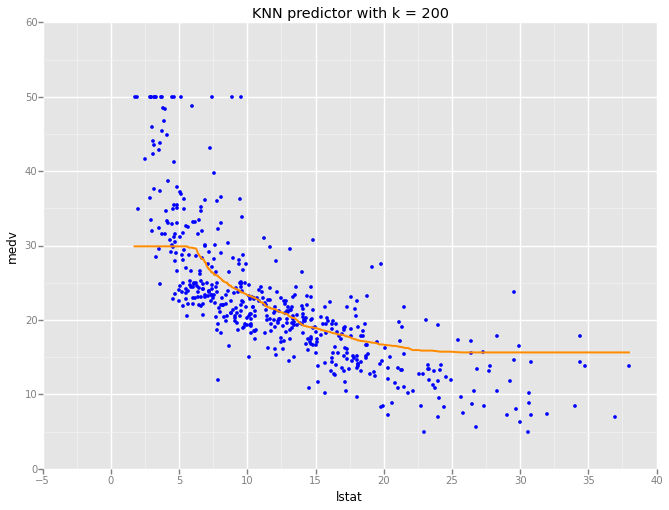

<ggplot: (282347237)>

In [123]:
k = 200
knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)
boston_housing['predicted_medv'] = knn_model.predict(boston_housing[['lstat']])

ggplot(aes(x='lstat', y='medv'), data=boston_housing) +\
    geom_point(size=10, color='blue') +\
    geom_line(aes(x='lstat', y='predicted_medv'), size=2, color='darkorange') +\
    ggtitle('KNN predictor with k = %i' % k) +\
    xlab('lstat') + ylab('medv')

_Meh..._, we're not exactly jumping around with joy with this one, either. The predictor line is **not over-sensitive**, but **too "smooth" and too simple**, **not responding sufficiently to significant changes** in _lstat_. We call this a **HIGH-BIAS, LOW-VARIANCE** predictor.

Let's try something in between, say, $k = 50$, to see if we have any better luck:

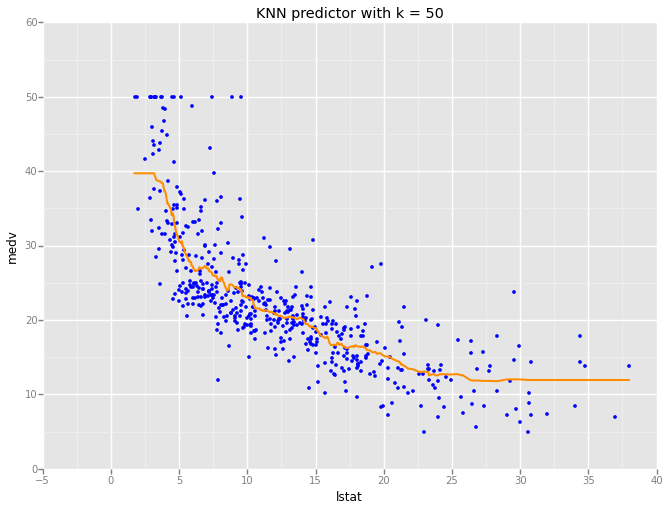

<ggplot: (284092713)>

In [124]:
k = 50
knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)
boston_housing['predicted_medv'] = knn_model.predict(boston_housing[['lstat']])

ggplot(aes(x='lstat', y='medv'), data=boston_housing) +\
    geom_point(size=10, color='blue') +\
    geom_line(aes(x='lstat', y='predicted_medv'), size=2, color='darkorange') +\
    ggtitle('KNN predictor with k = %i' % k) +\
    xlab('lstat') + ylab('medv')

Now, this looks pretty reasonable, and we'd think this predictor would **generalize well** when facing new, not yet seen, data. This is a **low-bias**, **low-variance** predictor. We love ones like this.

Hence, the key take-away is that, throughout a range of **hyper-parameter** $k$ from small to large, we have seen a spectrum of corresponding predictors from "low-bias high-variance" to "high-bias low-variance". This phenomenon is called the **BIAS-VARIANCE TRADE OFF**, a fundamental concept in Machine Learning that is applicable to not only KNN alone but to all modeling methods.

The bias-variance trade-off concerns the **generalizability of a trained predictor** in light of new data it's not seen before. If a predictor has high bias and/or high variance, it will not do well in new cases. **Good, generalizable predictors** need to have **both low bias and low variance**.

# Out-of-Sample Error and Cross-Validation

To **quantify the generalizability of a predictor**, we need to estimate its **out-of-sample (OOS) error**, i.e. a certain measure of **how well the predictor performs on data not used in its training process**.

A popular way to produce such OOS error estimates is to perform **cross validation**. Refer to lecture slides or <a href="http://en.wikipedia.org/wiki/Cross-validation_(statistics)">here</a> for discussions on cross validation.

Now, let's consider [**Root Mean Square Error** (**RMSE**)](http://en.wikipedia.org/wiki/Root-mean-square_deviation) as our predictor-goodness evaluation criterion and use **5-fold** cross validation **6 times** to pick a KNN predictor that has satisfactory RMSE.

In [125]:
# define Root-Mean-Square-Error scoring/evaluation function
# compliant with what SciKit Learn expects in this guide:
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score
def rmse_score(estimator, X, y):
    y_hat = estimator.predict(X)
    return rmse(y_hat, y)

NB_CROSS_VALIDATION_FOLDS = 5
NB_CROSS_VALIDATIONS = 6

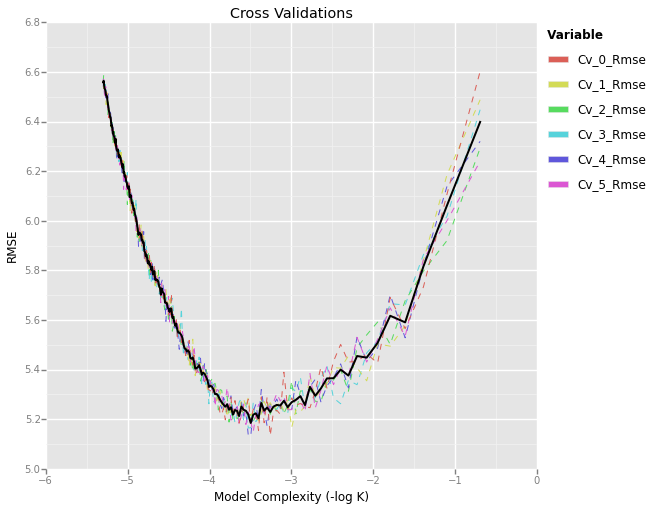

<ggplot: (282355277)>

In [126]:
k_range = range(2, 201)
cross_validations_avg_rmse_dataframe = DataFrame(dict(k=k_range, model_complexity=-log(k_range)))
cross_validations_avg_rmse_dataframe['cv_avg_rmse'] = 0.
cv_column_names = []
for v in range(NB_CROSS_VALIDATIONS):
    cv_column_name = 'cv_%i_rmse' % v
    cv_column_names.append(cv_column_name)
    cross_validations_avg_rmse_dataframe[cv_column_name] = nan
    for k in k_range:
        knn_model = KNeighborsRegressor(n_neighbors=k)
        avg_rmse_score = cross_val_score(
            knn_model,
            X=boston_housing[['lstat']],
            y=boston_housing.medv,
            cv=KFold(n=nb_samples,
                     n_folds=NB_CROSS_VALIDATION_FOLDS,
                     shuffle=True),
            scoring=rmse_score).mean()
        cross_validations_avg_rmse_dataframe.ix[
            cross_validations_avg_rmse_dataframe.k==k, cv_column_name] = avg_rmse_score
        
    cross_validations_avg_rmse_dataframe.cv_avg_rmse +=\
        (cross_validations_avg_rmse_dataframe[cv_column_name] -
         cross_validations_avg_rmse_dataframe.cv_avg_rmse) / (v + 1)
        
cross_validations_avg_rmse_longdataframe = melt(
    cross_validations_avg_rmse_dataframe,
    id_vars=['model_complexity', 'cv_avg_rmse'], value_vars=cv_column_names)

ggplot(aes(x='model_complexity', y='value', color='variable'),
       data=cross_validations_avg_rmse_longdataframe) +\
    geom_line(size=1, linetype='dashed') +\
    geom_line(aes(x='model_complexity', y='cv_avg_rmse'),
              data=cross_validations_avg_rmse_longdataframe,
              size=2, color='black') +\
    ggtitle('Cross Validations') +\
    xlab('Model Complexity (-log K)') + ylab('RMSE')

Best $k$ that minimizes average cross-validation RMSE:

In [127]:
best_k_index = cross_validations_avg_rmse_dataframe.cv_avg_rmse.argmin()
best_k = k_range[best_k_index]
best_k

33

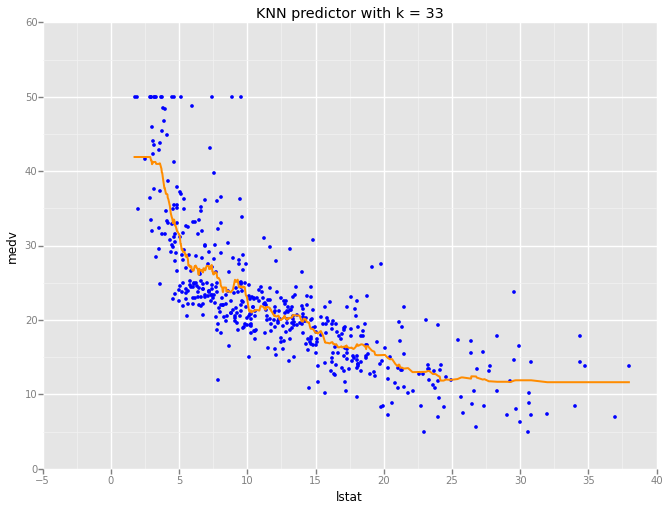

<ggplot: (282116261)>

In [128]:
k = best_k
knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)
boston_housing['predicted_medv'] = knn_model.predict(boston_housing[['lstat']])

ggplot(aes(x='lstat', y='medv'), data=boston_housing) +\
    geom_point(size=10, color='blue') +\
    geom_line(aes(x='lstat', y='predicted_medv'), size=2, color='darkorange') +\
    ggtitle('KNN predictor with k = %i' % k) +\
    xlab('lstat') + ylab('medv')